In [1]:
# load python libraries
import sys
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['axes.titlesize'] = 20 # set global title size for plots

# load custom libraries
sys.path.append("../tools")
from utils import *

In [2]:
# allow jupyter notebook to measure memory consumption
%load_ext memory_profiler

In [3]:
# load data for training and evaluation
train_img_paths, train_img_labels, test_img_paths, test_img_labels, labels = get_paths_and_labels()

# Alternative 2
This notebook implements a series of operations for the task of raindrop detection. These operations include foreground extraction, image filtering and segmentation, connected-component analysis, and finally, blob detection. Ultimately, it evaluates the feasibility of using the number of detected raindrops for the task of binary classification.

## Foreground Extraction
### Remove background
**First step:** As raindrops lay on the camera lenses, they will be considered foreground. Hence, removing the background should help us detect raindrops more easily

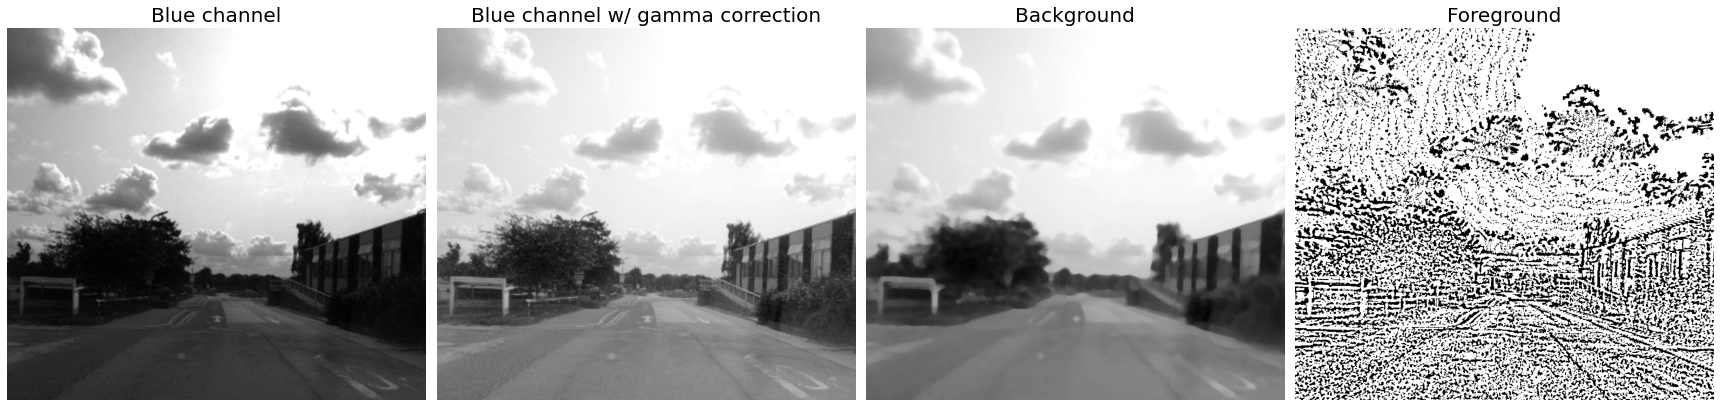

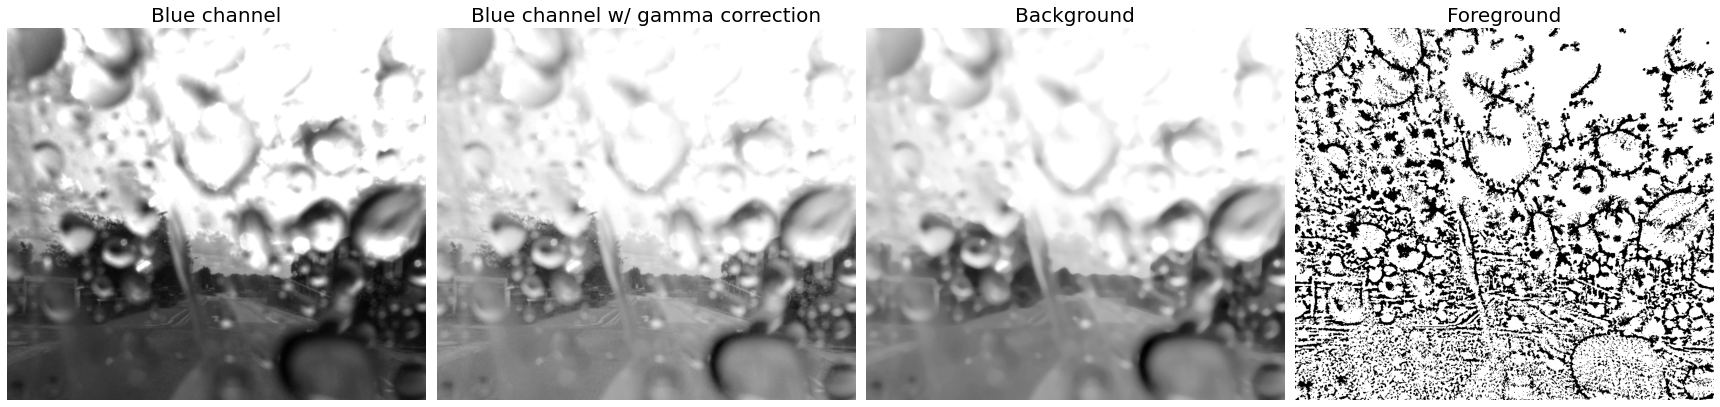

In [4]:
idx = 2
for i in [idx,idx+503]:

    im = cv2.imread(train_img_paths[i]) # load image as BGR
    im_b = im[...,0] # get blue channel
    
    # gamma correction
    gamma = 0.2
    im_gamma = im_b/255.
    im_gamma = np.power(im_gamma,gamma)
    im_gamma = np.clip(255*im_gamma,0,255)
    im_gamma = im_gamma.astype(np.uint8)
    
    # foreground detection
    eps = 0.001
    im_bg = cv2.medianBlur(im_gamma,11)
    im_fg = (im_gamma/255.)/np.maximum(eps,im_bg)
    im_fg = 255*np.minimum(im_fg,1)
    im_fg = 255*im_fg.astype(np.uint8)
    
    fig, ax = plt.subplots(1,4,figsize=(24,6))
    plt.setp(ax,xticks=[],yticks=[],frame_on=False)

    ax[0].imshow(im_b,cmap='gray')
    ax[0].set_title('Blue channel')

    ax[1].imshow(im_gamma,cmap='gray')
    ax[1].set_title('Blue channel w/ gamma correction')

    ax[2].imshow(im_bg,cmap='gray')
    ax[2].set_title('Background')
    
    ax[3].imshow(im_fg,cmap='gray')
    ax[3].set_title('Foreground')

    fig.tight_layout()
    plt.show()

## Filtering
**Second step:** Now the image looks noisy, so let's use some filters to decrease the noise. Gaussian filters smooth the image by bluring it, while median filters create more contrast by eliminating the small noise.

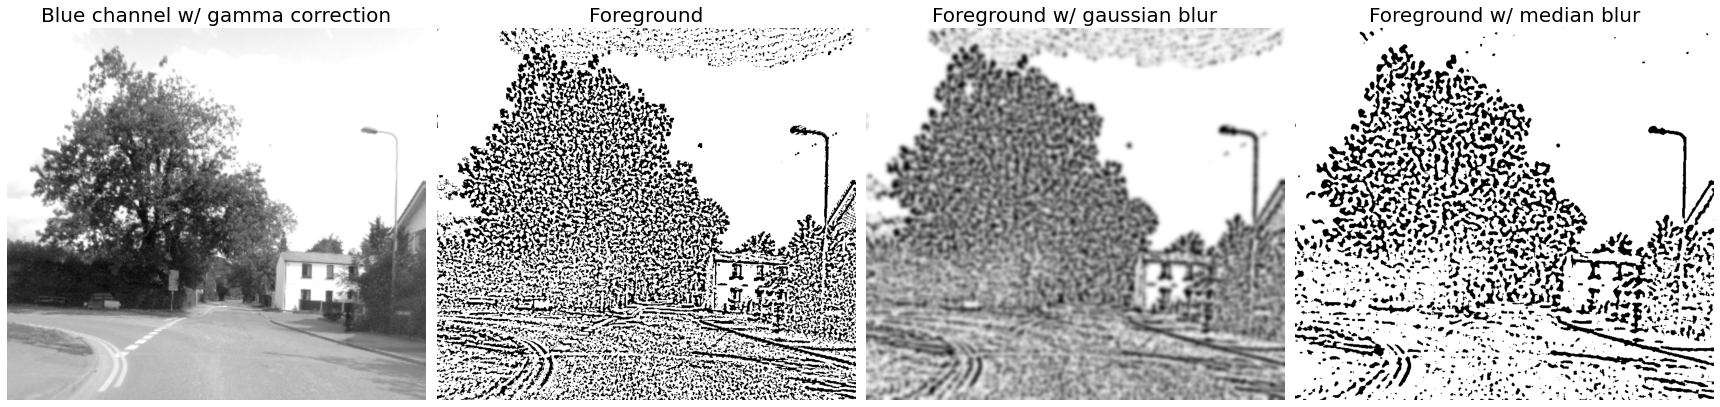

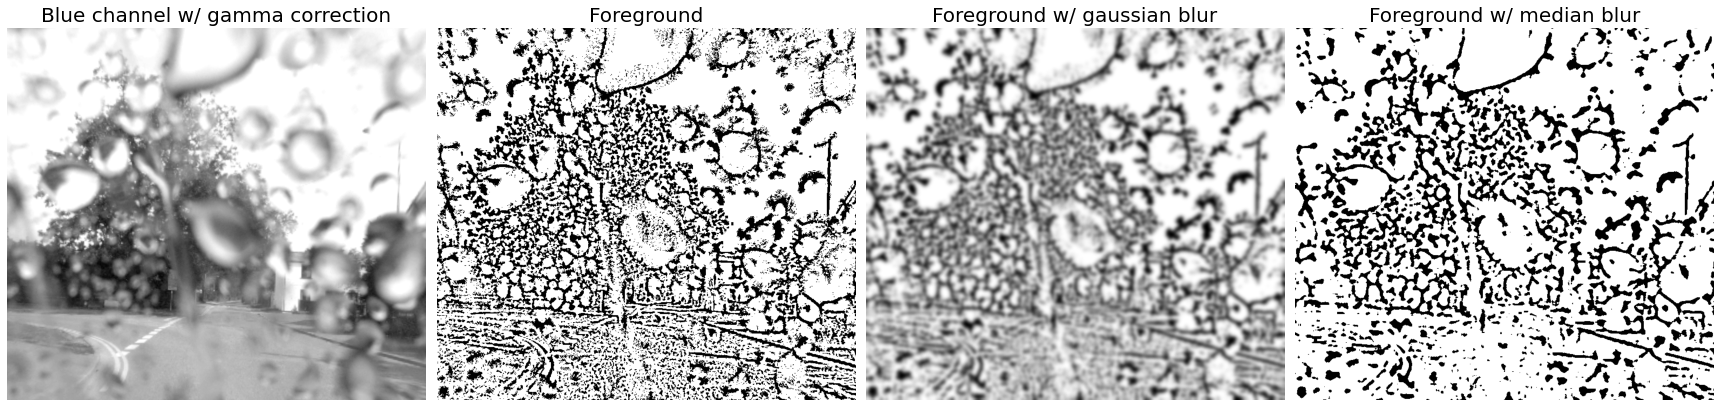

In [5]:
idx = 0
for i in [idx,idx+503]:
    
    im = cv2.imread(train_img_paths[i]) # load image as BGR
    im_b = im[...,0] # get blue channel
    
    # gamma correction
    gamma = 0.2
    im_gamma = im_b/255.
    im_gamma = np.power(im_gamma,gamma)
    im_gamma = np.clip(255*im_gamma,0,255)
    im_gamma = im_gamma.astype(np.uint8)
    
    # foreground detection
    eps = 0.001
    im_bg = cv2.medianBlur(im_gamma,11)
    im_fg = (im_gamma/255.)/np.maximum(eps,im_bg)
    im_fg = 255*np.minimum(im_fg,1)
    im_fg = 255*im_fg.astype(np.uint8)
    
    im_blur1 = cv2.GaussianBlur(im_fg,(21,21),0) # applying gaussian blur
    im_blur2 = cv2.medianBlur(im_fg,7) # applying median blur
    
    fig, ax = plt.subplots(1,4,figsize=(24,6))
    plt.setp(ax,xticks=[],yticks=[],frame_on=False)

    ax[0].imshow(im_gamma,cmap='gray')
    ax[0].set_title('Blue channel w/ gamma correction')

    ax[1].imshow(im_fg,cmap='gray')
    ax[1].set_title('Foreground')

    ax[2].imshow(im_blur1,cmap='gray')
    ax[2].set_title('Foreground w/ gaussian blur')
    
    ax[3].imshow(im_blur2,cmap='gray')
    ax[3].set_title('Foreground w/ median blur')

    fig.tight_layout()
    plt.show()

## Segmentation
**Third step:** Now that I have a cleaner image, let's create a mask, which is a binary image with only back or white pixels. This mask should help us localize raindrops more easily.

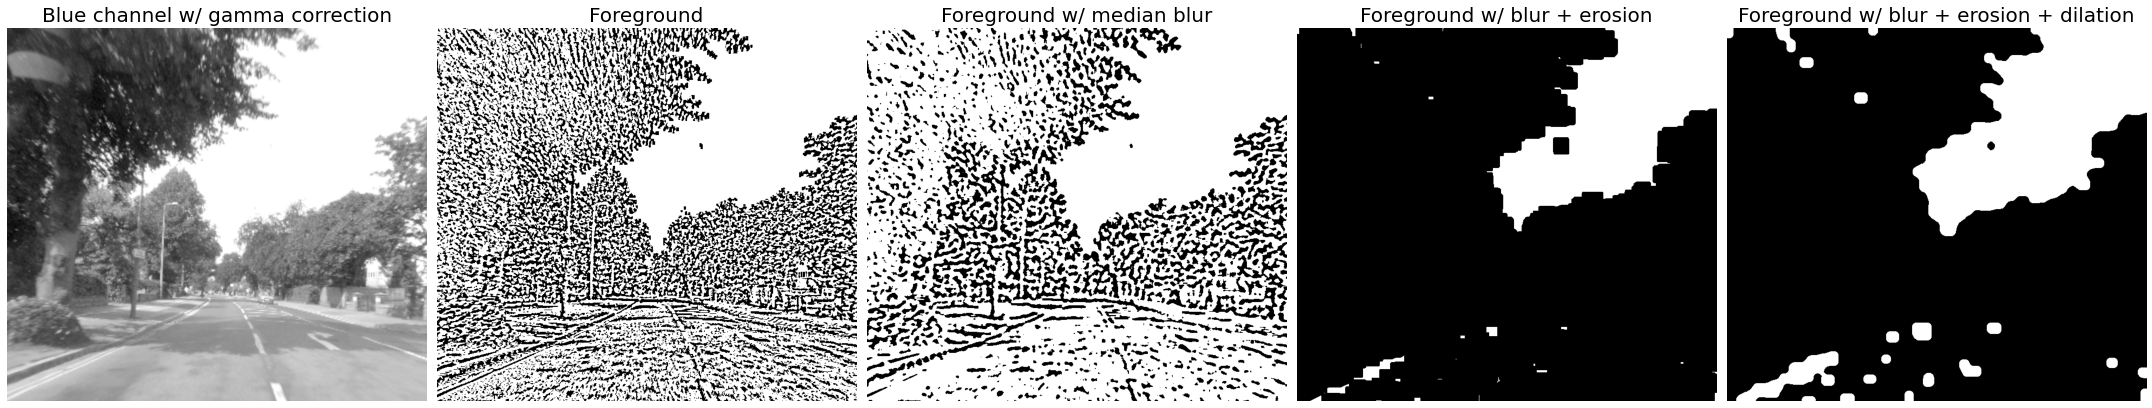

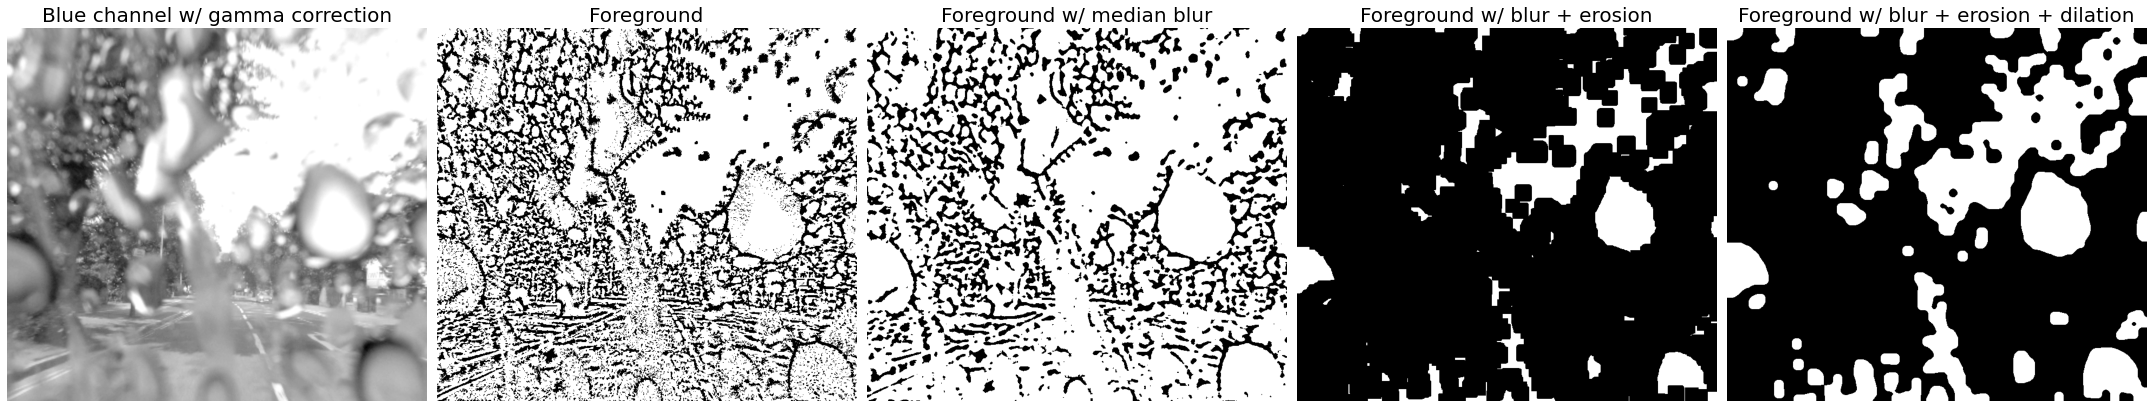

In [6]:
idx = 5
for i in [idx,idx+503]:
    
    im = cv2.imread(train_img_paths[i]) # load image as BGR
    im_b = im[...,0] # get blue channel
    
    # gamma correction
    gamma = 0.2
    im_gamma = im_b/255.
    im_gamma = np.power(im_gamma,gamma)
    im_gamma = np.clip(255*im_gamma,0,255)
    im_gamma = im_gamma.astype(np.uint8)
    
    # foreground detection
    eps = 0.001
    im_bg = cv2.medianBlur(im_gamma,11)
    im_fg = (im_gamma/255.)/np.maximum(eps,im_bg)
    im_fg = 255*np.minimum(im_fg,1)
    im_fg = 255*im_fg.astype(np.uint8)
    
    # filtering and segmentation        
    im_blur = cv2.medianBlur(im_fg,7)
    im_erode = cv2.erode(im_blur,None,iterations=12)
    im_dilate = cv2.dilate(im_erode,None,iterations=8)
    im_dilate = cv2.medianBlur(im_dilate,11)
    
    fig, ax = plt.subplots(1,5,figsize=(30,6))
    plt.setp(ax,xticks=[],yticks=[],frame_on=False)

    ax[0].imshow(im_gamma,cmap='gray')
    ax[0].set_title('Blue channel w/ gamma correction')
    
    ax[1].imshow(im_fg,cmap='gray')
    ax[1].set_title('Foreground')

    ax[2].imshow(im_blur,cmap='gray')
    ax[2].set_title('Foreground w/ median blur')

    ax[3].imshow(im_erode,cmap='gray')
    ax[3].set_title('Foreground w/ blur + erosion')
    
    ax[4].imshow(im_dilate,cmap='gray')
    ax[4].set_title('Foreground w/ blur + erosion + dilation')

    fig.tight_layout()
    plt.show()

## Connected Components Analysis
**Fourth step:** After segmentation, the image still shows some residual white pixels. A good way to get rid of this is using connected-components analysis to highlight big white areas and remove the small isolated white areas in a mask.

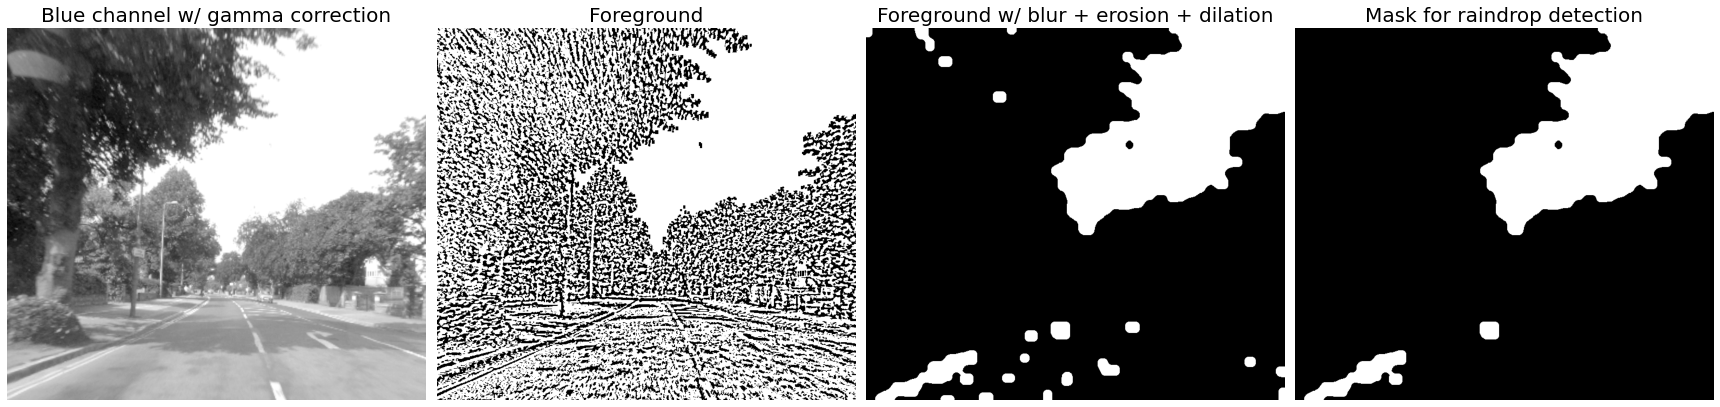

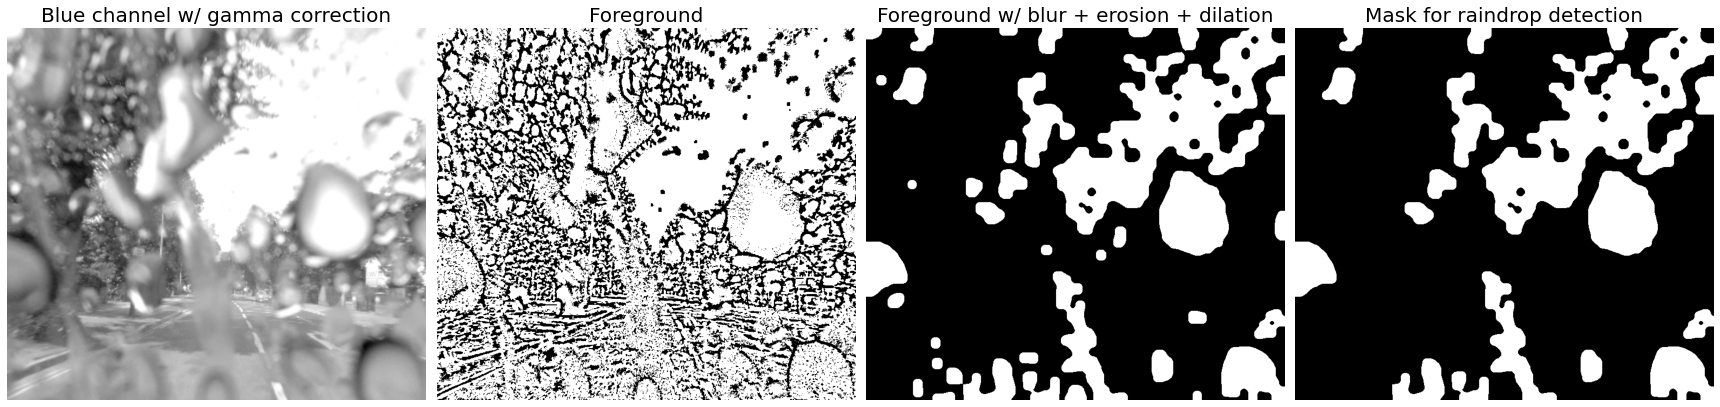

In [7]:
idx = 5
for i in [idx,idx+503]:
    
    im = cv2.imread(train_img_paths[i]) # load image as BGR
    im_b = im[...,0] # get blue channel
    
    # gamma correction
    gamma = 0.2
    im_gamma = im_b/255.
    im_gamma = np.power(im_gamma,gamma)
    im_gamma = np.clip(255*im_gamma,0,255)
    im_gamma = im_gamma.astype(np.uint8)
    
    # foreground detection
    eps = 0.001
    im_bg = cv2.medianBlur(im_gamma,11)
    im_fg = (im_gamma/255.)/np.maximum(eps,im_bg)
    im_fg = 255*np.minimum(im_fg,1)
    im_fg = 255*im_fg.astype(np.uint8)
    
    # filtering and segmentation        
    im_blur = cv2.medianBlur(im_fg,7)
    im_erode = cv2.erode(im_blur,None,iterations=12)
    im_dilate = cv2.dilate(im_erode,None,iterations=8)
    im_dilate = cv2.medianBlur(im_dilate,11)

    # connected-component analysis
    im_components = cv2.connectedComponents(im_dilate)[1]
    im_mask = np.zeros(im_dilate.shape, dtype="uint8")

    for component in np.unique(im_components):
        
        if component == 0: continue
            
        component_mask = np.zeros(im_dilate.shape, dtype="uint8")
        component_mask[im_components == component] = 255
        
        numPixels = cv2.countNonZero(component_mask)
        if numPixels > 1000: im_mask = cv2.add(im_mask, component_mask)
    
    fig, ax = plt.subplots(1,4,figsize=(24,6))
    plt.setp(ax,xticks=[],yticks=[],frame_on=False)

    ax[0].imshow(im_gamma,cmap='gray')
    ax[0].set_title('Blue channel w/ gamma correction')
    
    ax[1].imshow(im_fg,cmap='gray')
    ax[1].set_title('Foreground')

    ax[2].imshow(im_dilate,cmap='gray')
    ax[2].set_title('Foreground w/ blur + erosion + dilation')
    
    ax[3].imshow(im_mask,cmap='gray')
    ax[3].set_title('Mask for raindrop detection')

    fig.tight_layout()
    plt.show()

## Blob Detection
**Fifth step:** Given that the image looks cleaner and the geometric shapes of the white ares in the mask are easier to identify, I can finally apply blob detection to detect round white areas or "blobs" from a mask.

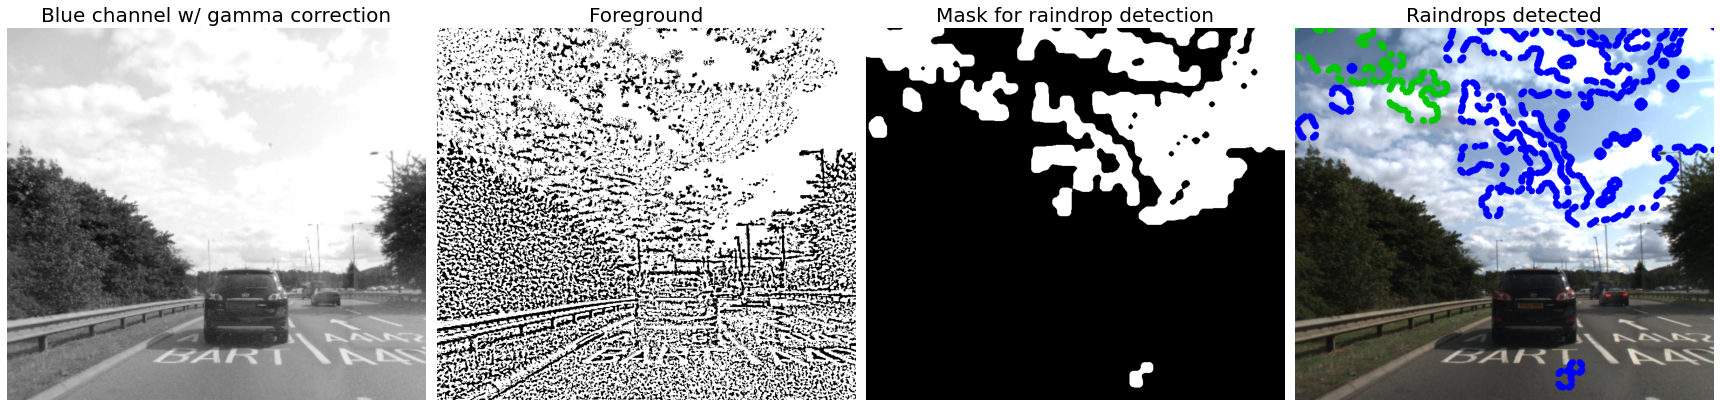

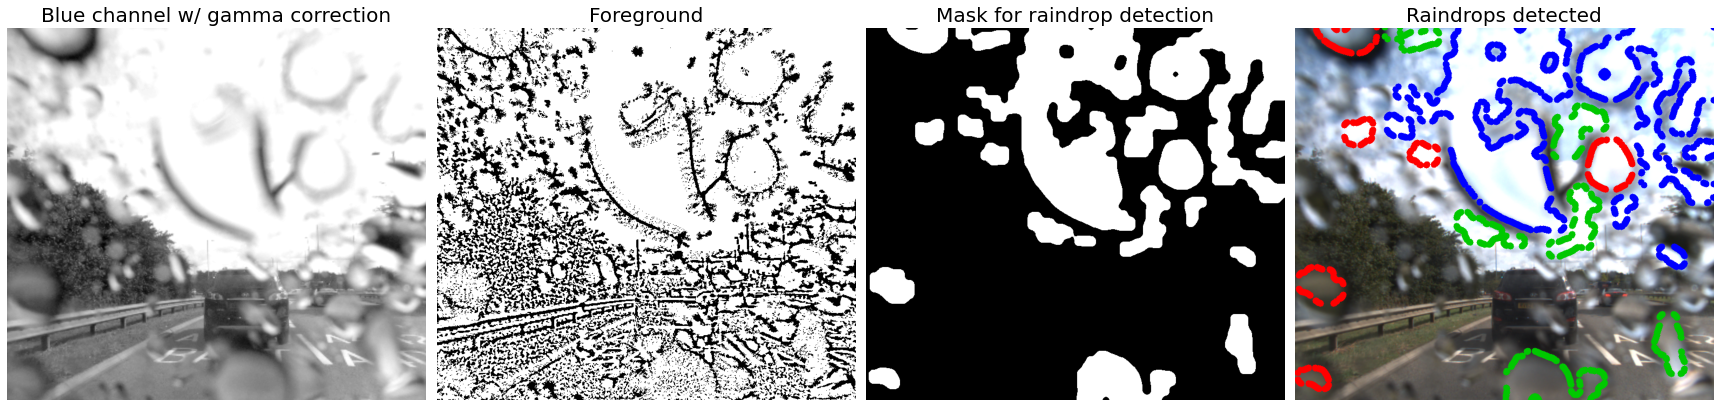

In [8]:
idx = 3
for i in [idx,idx+503]:
    
    im = cv2.imread(train_img_paths[i]) # load image as BGR
    im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB) # BGR -> RGB
    im_b = im[...,2] # get blue channel
    
    # gamma correction
    gamma = 0.2
    im_gamma = im_b/255.
    im_gamma = np.power(im_gamma,gamma)
    im_gamma = np.clip(255*im_gamma,0,255)
    im_gamma = im_gamma.astype(np.uint8)
    
    # foreground detection
    eps = 0.001
    im_bg = cv2.medianBlur(im_gamma,11)
    im_fg = (im_gamma/255.)/np.maximum(eps,im_bg)
    im_fg = 255*np.minimum(im_fg,1)
    im_fg = 255*im_fg.astype(np.uint8)
    
    # filtering and segmentation        
    im_blur = cv2.medianBlur(im_fg,7)
    im_erode = cv2.erode(im_blur,None,iterations=12)
    im_dilate = cv2.dilate(im_erode,None,iterations=8)
    im_dilate = cv2.medianBlur(im_dilate,11)
    
    # connected-component analysis
    im_components = cv2.connectedComponents(im_dilate)[1]
    im_mask = np.zeros(im_dilate.shape, dtype="uint8")

    for component in np.unique(im_components):
        
        if component == 0: continue
            
        component_mask = np.zeros(im_dilate.shape, dtype="uint8")
        component_mask[im_components == component] = 255
        
        numPixels = cv2.countNonZero(component_mask)
        if numPixels > 1000: im_mask = cv2.add(im_mask, component_mask)
    
    # blob detection       
    contours = cv2.findContours(im_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
    
    # draw all blobs with a blue contour
    for contour in contours:
        cv2.drawContours(im, contour, -1, (0, 0, 255), thickness=11)
    
    # check if the area of the blob is between the minimum and maximum allowed
    contours_area = []
    for con in contours:
        area = cv2.contourArea(con)
        if 1600 < area < 16000:
            contours_area.append(con)
    
    # draw all blobs that satisfy the area condition with a green contour            
    for contour in contours_area:
        cv2.drawContours(im, contour, -1, (0, 200, 0), thickness=11)

    # check if the contour of the blob roughly describes a circular shape
    contours_cirles = []
    for con in contours_area:
        perimeter = cv2.arcLength(con, True)
        area = cv2.contourArea(con)
        if perimeter == 0:
            break
        circularity = 4*np.pi*(area/(perimeter*perimeter))
        if 0.6 < circularity < 1.2:
            contours_cirles.append(con)
    
    # draw all blobs that satisfy the area and circularity conditions with a red contour                 
    for contour in contours_cirles:
        cv2.drawContours(im, contour, -1, (255, 0, 0), thickness=11)
            
    fig, ax = plt.subplots(1,4,figsize=(24,6))
    plt.setp(ax,xticks=[],yticks=[],frame_on=False)

    ax[0].imshow(im_gamma,cmap='gray')
    ax[0].set_title('Blue channel w/ gamma correction')
    
    ax[1].imshow(im_fg,cmap='gray')
    ax[1].set_title('Foreground')

    ax[2].imshow(im_mask,cmap='gray')
    ax[2].set_title('Mask for raindrop detection')
    
    ax[3].imshow(im,cmap='gray')
    ax[3].set_title('Raindrops detected')

    fig.tight_layout()
    plt.show()

## Test classification using raindrop detection
**Sixth step:** Test the classification performance when using raindrop detection by counting the number of raindrops detected per image and finding a suitable threshold for binary classififcation.

In [9]:
number_of_raindrops_per_image = []

for i in train_img_paths:
    
    im = cv2.imread(i) # load image as BGR
    im_b = im[...,0] # get blue channel
    
    # gamma correction
    gamma = 0.2
    im_gamma = im_b/255.
    im_gamma = np.power(im_gamma,gamma)
    im_gamma = np.clip(255*im_gamma,0,255)
    im_gamma = im_gamma.astype(np.uint8)
    
    # foreground detection
    eps = 0.001
    im_bg = cv2.medianBlur(im_gamma,11)
    im_fg = (im_gamma/255.)/np.maximum(eps,im_bg)
    im_fg = 255*np.minimum(im_fg,1)
    im_fg = 255*im_fg.astype(np.uint8)
      
    # filtering and segmentation
    im_blur = cv2.medianBlur(im_fg,7)
    im_erode = cv2.erode(im_blur,None,iterations=12)
    im_dilate = cv2.dilate(im_erode,None,iterations=8)
    im_dilate = cv2.medianBlur(im_dilate,11)

    # connected-component analysis
    im_components = cv2.connectedComponents(im_dilate)[1]
    im_mask = np.zeros(im_dilate.shape, dtype="uint8")

    for component in np.unique(im_components):
        
        if component == 0: continue
            
        component_mask = np.zeros(im_dilate.shape, dtype="uint8")
        component_mask[im_components == component] = 255
        
        numPixels = cv2.countNonZero(component_mask)
        if numPixels > 1000: im_mask = cv2.add(im_mask, component_mask)
       
    # blob detection
    contours = cv2.findContours(im_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
    
    # check if the area of the blob is between the minimum and maximum allowed
    contours_area = []
    for con in contours:
        area = cv2.contourArea(con)
        if 1600 < area < 16000:
            contours_area.append(con)

    # check if the contour of the blob roughly describes a circular shape
    contours_cirles = []
    for con in contours_area:
        perimeter = cv2.arcLength(con, True)
        area = cv2.contourArea(con)
        if perimeter == 0:
            break
        circularity = 4*np.pi*(area/(perimeter*perimeter))
        if 0.6 < circularity < 1.2:
            contours_cirles.append(con)
    
    # count number of blobs that satisfied the area and circularity conditions
    number_of_raindrops = len(contours_cirles)
    number_of_raindrops_per_image.append(number_of_raindrops)

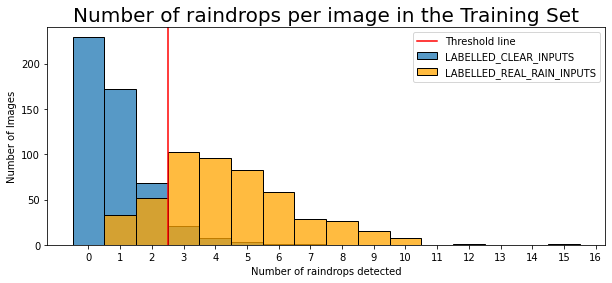

In [10]:
plt.figure(figsize=(10,4))
sns.histplot(np.array(number_of_raindrops_per_image)[np.array(train_img_labels)==labels[0]],discrete=True,label=labels[0])
sns.histplot(np.array(number_of_raindrops_per_image)[np.array(train_img_labels)==labels[1]],discrete=True,color='orange',label=labels[1])
plt.plot([2.5,2.5],[0,250],c='red',label='Threshold line')
plt.xticks(range(17))
plt.ylim(0,240)
plt.legend()
plt.xlabel('Number of raindrops detected')
plt.ylabel('Number of Images')
plt.title('Number of raindrops per image in the Training Set')
plt.show()

## Define proposed pipeline
**Seventh step:** Create the final pipeline so that an RGB image is taken as input and the output is a predicted label. For the pipeline below, I used a threshold of 3 detected raindrops for the minimum an image must have to be consider a raindrop image.

In [11]:
def pipeline(query_image):

    im_b = query_image[...,2] # get blue channel
    
    # gamma correction
    gamma = 0.2
    im_gamma = im_b/255.
    im_gamma = np.power(im_gamma,gamma)
    im_gamma = np.clip(255*im_gamma,0,255)
    im_gamma = im_gamma.astype(np.uint8)
    
    # foreground detection
    eps = 0.001
    im_bg = cv2.medianBlur(im_gamma,11)
    im_fg = (im_gamma/255.)/np.maximum(eps,im_bg)
    im_fg = 255*np.minimum(im_fg,1)
    im_fg = 255*im_fg.astype(np.uint8)
    
    # filtering and segmentation
    im_blur = cv2.medianBlur(im_fg,7)
    im_erode = cv2.erode(im_blur,None,iterations=12)
    im_dilate = cv2.dilate(im_erode,None,iterations=8)
    im_dilate = cv2.medianBlur(im_dilate,11)

    # connected-component analysis
    im_components = cv2.connectedComponents(im_dilate)[1]
    im_mask = np.zeros(im_dilate.shape, dtype="uint8")

    for component in np.unique(im_components):
        
        if component == 0: continue
            
        component_mask = np.zeros(im_dilate.shape, dtype="uint8")
        component_mask[im_components == component] = 255
        
        numPixels = cv2.countNonZero(component_mask)
        if numPixels > 1000: im_mask = cv2.add(im_mask, component_mask)
    
    # blob detection
    contours = cv2.findContours(im_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
    
    contours_area = []
    # check if the area of the blob is between the minimum and maximum allowed
    for con in contours:
        area = cv2.contourArea(con)
        if 1600 < area < 16000:
            contours_area.append(con)

    contours_cirles = []
    # check if the contour of the blob roughly describes a circular shape
    for con in contours_area:
        perimeter = cv2.arcLength(con, True)
        area = cv2.contourArea(con)
        if perimeter == 0:
            break
        circularity = 4*np.pi*(area/(perimeter*perimeter))
        if 0.6 < circularity < 1.2:
            contours_cirles.append(con)
    
    # count number of blobs that satisfied the area and circularity conditions
    number_of_raindrops = len(contours_cirles)
    # classify between clear or raindrop images based on the number of blobs
    label = 'LABELLED_CLEAR_INPUTS' if number_of_raindrops<2 else 'LABELLED_REAL_RAIN_INPUTS'
    
    return label

## Final Results
### Classify images in the evaluation folder
**Eighth step:** Test the performance of the proposed pipeline using the images in the evaluation folder.

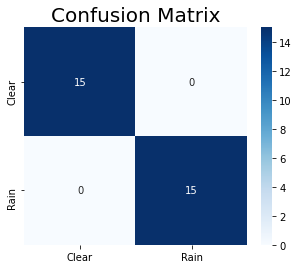

Clear Classification
--------------------
Precision: 1.00 - Recall: 1.00

Raindrop Classification
--------------------
Precision: 1.00 - Recall: 1.00



In [12]:
# run pipeline for all images in the evaluation folder
y_pred = [pipeline(cv2.cvtColor(cv2.imread(i),cv2.COLOR_BGR2RGB)) for i in test_img_paths]
# show results (confusion matrix, precision and recall)
show_results(test_img_labels,y_pred,labels)

### Measure computing time and RAM memory needed to run the proposed pipeline
This will be useful information as the computational power of drones is often limited.

In [13]:
# load a sample image (any image from the data is ok)
sample_query_image = cv2.cvtColor(cv2.imread(test_img_paths[0]),cv2.COLOR_BGR2RGB)

In [14]:
# Time the process of going through the pipeline
%timeit pipeline(sample_query_image)

107 ms ± 1.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [15]:
# Measure the RAM memory needed to go through the pipeline
%memit pipeline(sample_query_image)

peak memory: 226.85 MiB, increment: 3.14 MiB
